In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

op ='win'
if op == 'win':
    path = f'C:/Users/fabau/OneDrive/Documents/GitHub/master-project/'
else:
    path = f'/Users/fabienaugsburger/Documents/GitHub/master-project/'

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
# import the dataset

X_train = np.load(f'{path}DATASETS/X_y/X_train.npy')
X_test = np.load(f'{path}DATASETS/X_y/X_test.npy')
y_train = np.load(f'{path}DATASETS/X_y/y_train.npy')
y_test = np.load(f'{path}DATASETS/X_y/y_test.npy')

X_validation = np.load(f'{path}DATASETS/X_y/X_validation.npy')
y_validation = np.load(f'{path}DATASETS/X_y/y_validation.npy')

def from_np_to_torch(dataset):
    return torch.from_numpy(dataset).float().to(device)

def from_nan_to_zero(dataset):
    dataset = np.nan_to_num(dataset)
    return dataset

test = from_np_to_torch(from_nan_to_zero(y_train))

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

class Gia3DModel(nn.Module):
    def __init__(self, input_shape, output_length):
        super(Gia3DModel, self).__init__()
        self.input_shape = input_shape
        
        # Define the layers
        self.lstm1 = nn.LSTM(input_size=input_shape[1], hidden_size=128, batch_first=True)
        self.fc1 = nn.Linear(128, 128)
        self.flatten = nn.Flatten()
        
        # Calculate the flattened size
        self.flattened_size = 128 * input_shape[1]
        self.fc2 = nn.Linear(self.flattened_size, output_length)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 128).to(x.device)
        c0 = torch.zeros(1, x.size(0), 128).to(x.device)
        
        # LSTM layer
        out, _ = self.lstm1(x, (h0, c0))
        
        # Fully connected layer
        out = self.fc1(out[:, -1, :])
        out = torch.tanh(out)
        
        # Flatten
        out = self.flatten(out)
        
        # Output layer
        out = self.fc2(out)
        
        return out

# Assuming X_train is already defined and scaled
input_shape = (X_train.shape[1], X_train.shape[2])
output_length = y_train.shape[1]

# Initialize the model
model_Gia_3d = Gia3DModel(input_shape=input_shape, output_length=output_length)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_Gia_3d.parameters(), lr=0.001)

# Print the model summary
print(model_Gia_3d)

# Example usage
# X_train should be a PyTorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
outputs = model_Gia_3d(X_train_tensor)
print(outputs)

Gia3DModel(
  (lstm1): LSTM(68, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc2): Linear(in_features=8704, out_features=472, bias=True)
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (67x128 and 8704x472)

In [7]:
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model_Gia_3d.train()  # Set model to training mode
    
    # Forward pass
    outputs = model_Gia_3d(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (67x128 and 60416x472)

In [32]:
# Impute NaN values with 0 (or use other strategies like mean/median imputation)
input_data = torch.where(torch.isnan(torch.tensor(X_train, dtype=torch.float32)), torch.zeros_like(torch.tensor(X_train, dtype=torch.float32)), torch.tensor(X_train, dtype=torch.float32))
target_data = torch.where(torch.isnan(torch.tensor(y_train, dtype=torch.float32)), torch.zeros_like(torch.tensor(y_train, dtype=torch.float32)), torch.tensor(y_train, dtype=torch.float32))

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

class WindGustPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dense_dim, output_dim):
        super(WindGustPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        #self.fc = nn.Linear(hidden_dim, output_dim)
        # Adding additional dense layers
        self.fc1 = nn.Linear(hidden_dim, dense_dim)
        self.fc2 = nn.Linear(dense_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        #OLD_out = self.fc(out[:, -1, :])  # Take the last time step's output
        #out = self.fc(out)  # Apply the fully connected layer to all time steps
        out = self.fc1(out)  # Apply the first fully connected layer
        out = torch.relu(out)  # Apply ReLU activation
        out = self.fc2(out)  # Apply the second fully connected layer
        return out

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                torch.nn.init.zeros_(param.data)

In [20]:
# Assume input_data is your input tensor with shape (storm number, hourly time steps, variables)
# and target_data is your target tensor with shape (storm number, hourly time steps, 1)
#input_data = torch.randn(67, 472, 68)  # Example data, replace with actual data
#target_data = torch.randn(67, 472, 1)  # Example data, replace with actual data

# change dimension of y_target to fit the model
target_data = from_np_to_torch(from_nan_to_zero(y_train)).unsqueeze(2)

# transfer the data to the device
input_data = from_np_to_torch(from_nan_to_zero(X_train))

# Hyperparameters
input_dim = 68
hidden_dim = 128
num_layers = 1
dense_dim = 128
output_dim = 1
num_epochs = 100000
learning_rate = 0.001

# Model, loss function, and optimizer
model = WindGustPredictor(input_dim, hidden_dim, num_layers, output_dim, dense_dim).to(device)
model.apply(init_weights)  # Initialize the model weights
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    outputs = model(input_data)
    loss = criterion(outputs, target_data)#target_data[:, -1, :])
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100000], Loss: 77.5322
Epoch [20/100000], Loss: 77.4386
Epoch [30/100000], Loss: 77.3446
Epoch [40/100000], Loss: 77.2509
Epoch [50/100000], Loss: 77.1579
Epoch [60/100000], Loss: 77.0654
Epoch [70/100000], Loss: 76.9735
Epoch [80/100000], Loss: 76.8820
Epoch [90/100000], Loss: 76.7910
Epoch [100/100000], Loss: 76.7003
Epoch [110/100000], Loss: 76.6101
Epoch [120/100000], Loss: 76.5202
Epoch [130/100000], Loss: 76.4307
Epoch [140/100000], Loss: 76.3415
Epoch [150/100000], Loss: 76.2526
Epoch [160/100000], Loss: 76.1641
Epoch [170/100000], Loss: 76.0759
Epoch [180/100000], Loss: 75.9880
Epoch [190/100000], Loss: 75.9005
Epoch [200/100000], Loss: 75.8132
Epoch [210/100000], Loss: 75.7263
Epoch [220/100000], Loss: 75.6396
Epoch [230/100000], Loss: 75.5533
Epoch [240/100000], Loss: 75.4672
Epoch [250/100000], Loss: 75.3815
Epoch [260/100000], Loss: 75.2960
Epoch [270/100000], Loss: 75.2109
Epoch [280/100000], Loss: 75.1260
Epoch [290/100000], Loss: 75.0414
Epoch [300/100000], Los

In [8]:
print(torch.isnan(input_data).sum())
print(torch.isnan(target_data).sum())

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


In [9]:
# Prepare the test data

data_test = from_np_to_torch(from_nan_to_zero(X_test))

# Set the model to evaluation mode
model.eval()

# Predict with the test data
with torch.no_grad():
    predictions = model(data_test)

# Now predictions contains the output of the model for X_test
predictions_np = predictions.cpu().numpy()
print(predictions_np)

[[[1.1968541e+01]
  [1.3767750e+01]
  [1.4043515e+01]
  ...
  [1.8607974e-03]
  [1.8607974e-03]
  [1.8607974e-03]]

 [[1.1968541e+01]
  [1.3767750e+01]
  [1.4043515e+01]
  ...
  [1.8607974e-03]
  [1.8607974e-03]
  [1.8607974e-03]]

 [[1.1968541e+01]
  [1.3767750e+01]
  [1.4043515e+01]
  ...
  [1.8607974e-03]
  [1.8607974e-03]
  [1.8607974e-03]]

 ...

 [[1.1968541e+01]
  [1.3767750e+01]
  [1.4043515e+01]
  ...
  [1.8607974e-03]
  [1.8607974e-03]
  [1.8607974e-03]]

 [[1.1968541e+01]
  [1.3767750e+01]
  [1.4043515e+01]
  ...
  [1.8607974e-03]
  [1.8607974e-03]
  [1.8607974e-03]]

 [[1.1968541e+01]
  [1.3767750e+01]
  [1.4043515e+01]
  ...
  [1.8607974e-03]
  [1.8607974e-03]
  [1.8607974e-03]]]


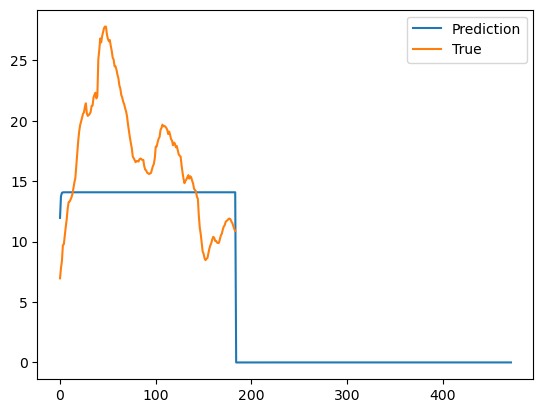

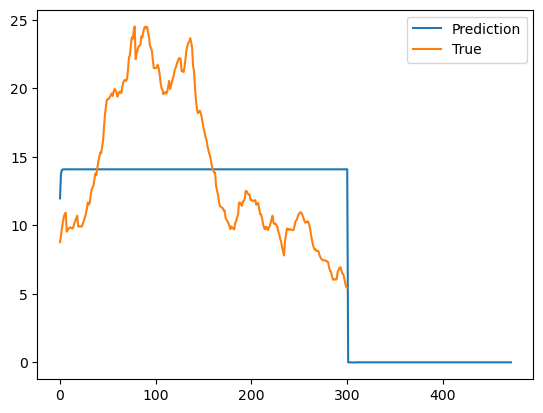

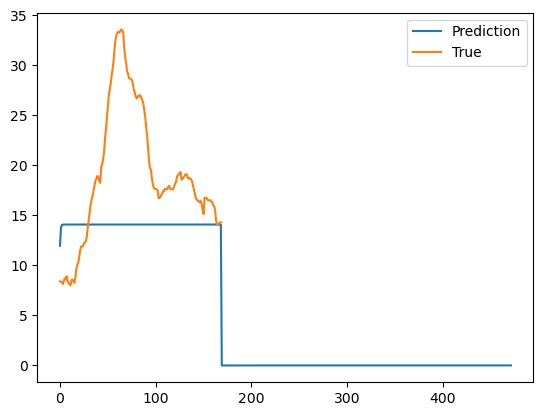

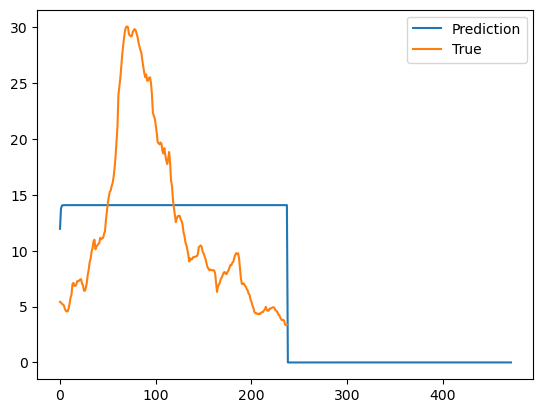

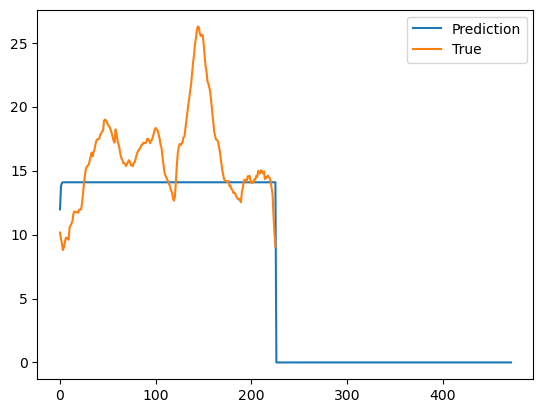

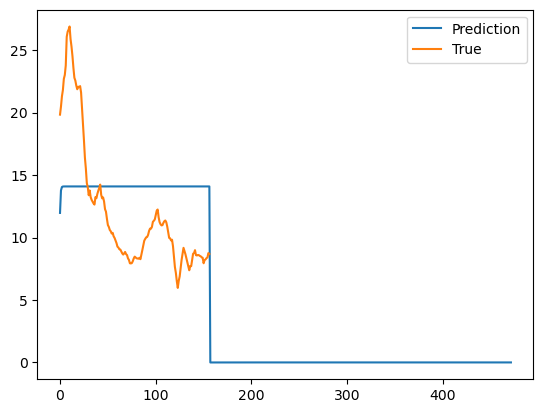

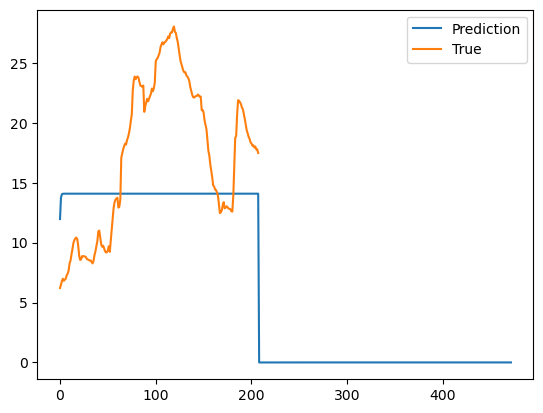

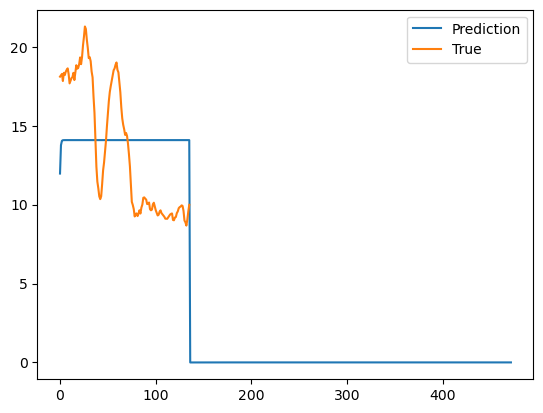

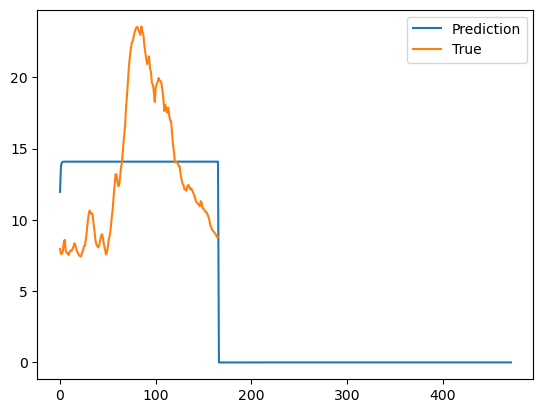

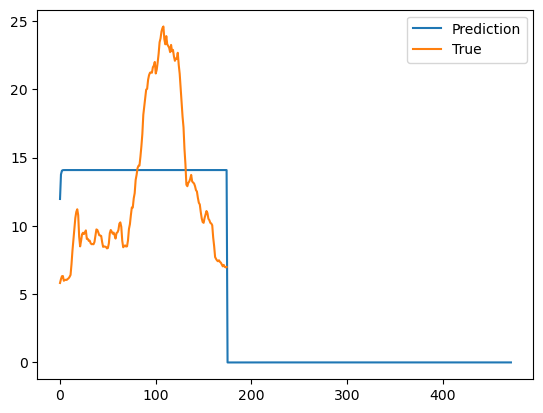

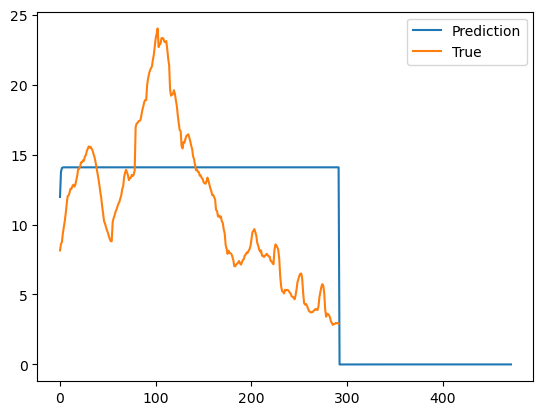

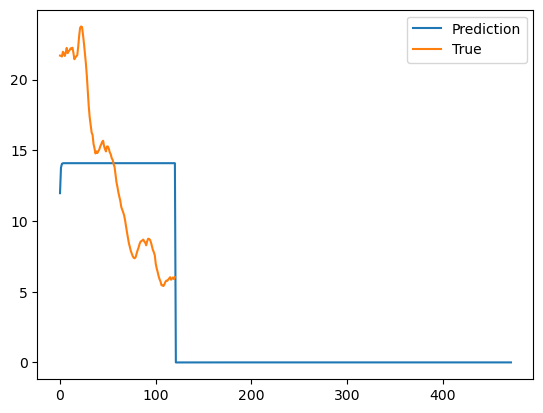

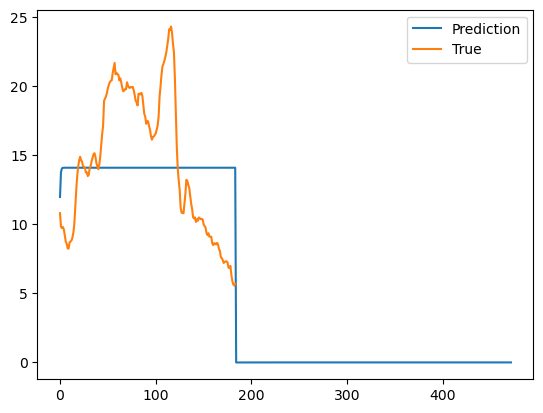

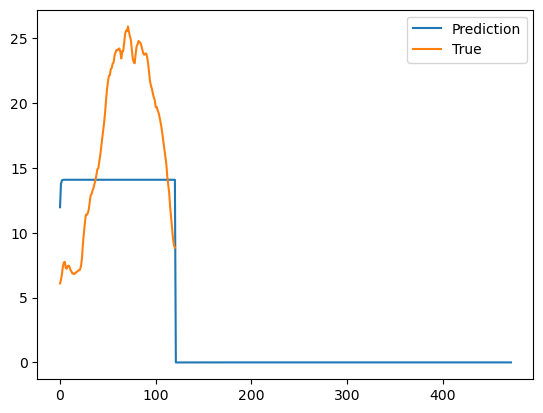

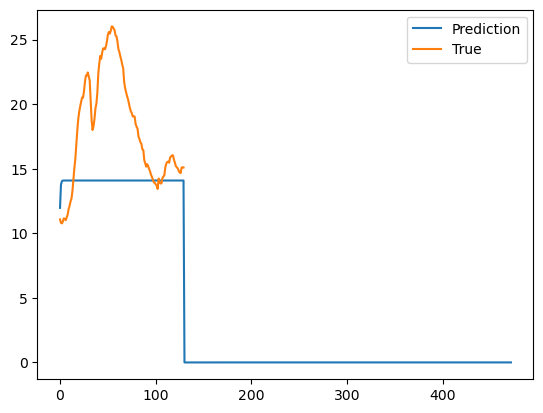

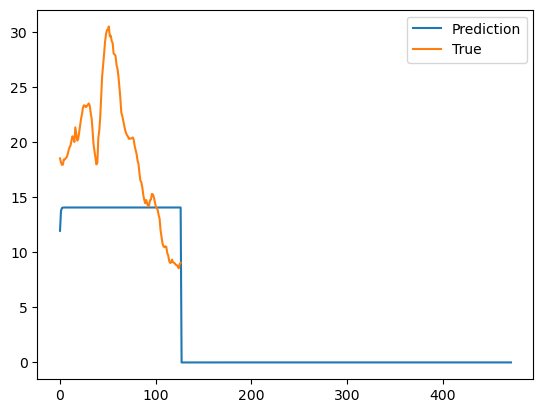

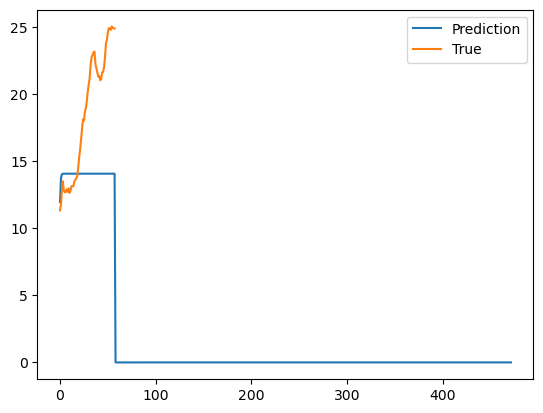

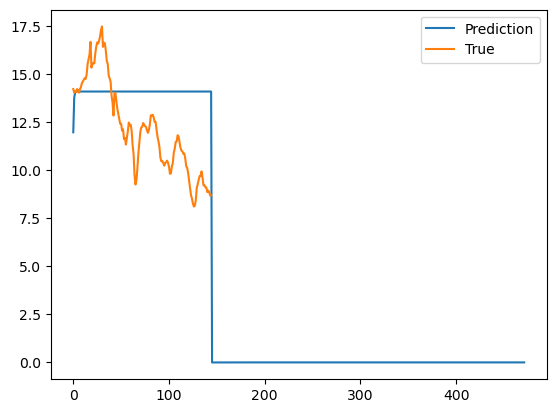

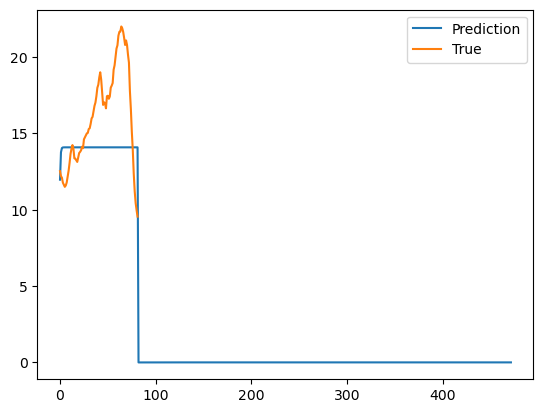

In [10]:
import matplotlib.pyplot as plt

for i in range(19):
    plt.plot(predictions_np[i], label='Prediction')
    plt.plot(y_test[i], label='True')
    plt.legend()
    plt.show()

